<a href="https://colab.research.google.com/github/llamb993/Wind_Power_Prediction/blob/main/WindPowerPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
%load_ext tensorboard
import datetime
import xgboost as xgb
from xgboost import cv
from xgboost import XGBRegressor
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install scikeras

In [4]:
from tensorflow.keras import models
from sklearn.model_selection import RandomizedSearchCV
from scikeras.wrappers import KerasRegressor
from tensorflow.keras import models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import itertools
from sklearn.metrics import mean_absolute_error

In [5]:
X_test = pd.read_csv('/content/drive/My Drive/Wind_Power_Prediction/WindPowerX_test.csv')
X_train = pd.read_csv('/content/drive/My Drive/Wind_Power_Prediction/WindPowerX_train.csv')
y_train = pd.read_csv('/content/drive/My Drive/Wind_Power_Prediction/WindPowery_train.csv')
y_test = pd.read_csv('/content/drive/My Drive/Wind_Power_Prediction/WindPowery_test.csv')

In [6]:
X_train.index = pd.to_datetime(X_train['Time'])
X_train.drop(['Time'],axis=1,inplace=True)
y_train.index = pd.to_datetime(y_train['Time'])
y_train.drop(['Time'],axis=1,inplace=True)

In [7]:
X_test.index = pd.to_datetime(X_test['Time'])
X_test.drop(['Time'],axis=1,inplace=True)
y_test.index = pd.to_datetime(y_test['Time'])
y_test.drop(['Time'],axis=1,inplace=True)

In [10]:
# ###### LINEAR REGRESSION ########
parameters={'learning_rate':[0.1, 0.01, 0.001],
            'epochs':[5, 50, 100]}

#Create function returning a compiled network
def create_network(learning_rate = 0.1):
  mlr1 = models.Sequential([
  layers.Dense(units=1,input_shape=(X_train.shape[1],))])
  mlr1.compile(loss="mean_absolute_error",
               optimizer=tf.optimizers.Adam()),

  # Return compiled network
  return mlr1

# Wrap Keras model so it can be used by scikit-learn
multiple_linear_regression = KerasRegressor(model=create_network,
                                            loss=keras.losses.mean_absolute_error,
                                            epochs=1,
                                            verbose=1,
                                            batch_size=128,
                                            learning_rate=0.01)
tuning_model=RandomizedSearchCV(multiple_linear_regression,param_distributions=parameters,cv=3,verbose=3,n_iter=5,scoring='neg_mean_absolute_error')

tuning_model.fit(X_train,y_train)


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Epoch 1/100
115/115 [==============================] - 6s 3ms/step - loss: 717.3403
Epoch 2/100
115/115 [==============================] - 0s 3ms/step - loss: 716.2368
Epoch 3/100
115/115 [==============================] - 0s 4ms/step - loss: 715.1376
Epoch 4/100
115/115 [==============================] - 0s 3ms/step - loss: 714.0430
Epoch 5/100
115/115 [==============================] - 0s 3ms/step - loss: 712.9524
Epoch 6/100
115/115 [==============================] - 0s 2ms/step - loss: 711.8643
Epoch 7/100
115/115 [==============================] - 0s 2ms/step - loss: 710.7787
Epoch 8/100
115/115 [==============================] - 0s 2ms/step - loss: 709.6964
Epoch 9/100
115/115 [==============================] - 0s 2ms/step - loss: 708.6163
Epoch 10/100
115/115 [==============================] - 0s 2ms/step - loss: 707.5399
Epoch 11/100
115/115 [==============================] - 0s 2ms/step - loss: 706.4683
Epoch 12/100
1

RandomizedSearchCV(cv=3,
                   estimator=KerasRegressor(batch_size=128, learning_rate=0.01, loss=<function mean_absolute_error at 0x7b1eb67080d0>, model=<function create_network at 0x7b1ea2a027a0>),
                   n_iter=5,
                   param_distributions={'epochs': [5, 50, 100],
                                        'learning_rate': [0.1, 0.01, 0.001]},
                   scoring='neg_mean_absolute_error', verbose=3)

In [ ]:
# best hyperparameters
print(f'The best model hyperparameters for the linear regression are {tuning_model.best_params_}')
# best model score
print(f'The best model score for the linear regression is {tuning_model.best_score_}')

#print all model results
cvres = tuning_model.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

The best model hyperparameters for the linear regression are {'learning_rate': 0.1, 'epochs': 100}
The best model score for the linear regression is -626.1055308172282
26.808865629066457 {'learning_rate': 0.01, 'epochs': 5}
25.92691523619866 {'learning_rate': 0.1, 'epochs': 50}
26.812938876084647 {'learning_rate': 0.001, 'epochs': 5}
25.022100847395453 {'learning_rate': 0.1, 'epochs': 100}
25.929602262998895 {'learning_rate': 0.01, 'epochs': 50}


In [ ]:
#dataframe of all results
pd.DataFrame(tuning_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_epochs,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,5.480678,4.108317,0.215685,0.022335,0.01,5,"{'learning_rate': 0.01, 'epochs': 5}",-728.446110,-715.368871,-712.330848,-718.715276,6.991626,4
1,27.728652,9.761534,0.272929,0.095768,0.1,50,"{'learning_rate': 0.1, 'epochs': 50}",-682.430462,-667.854272,-666.330066,-672.204934,7.257267,2
2,2.821030,0.076100,0.268503,0.100548,0.001,5,"{'learning_rate': 0.001, 'epochs': 5}",-729.161602,-715.146869,-712.492602,-718.933691,7.312952,5
3,37.801576,2.512505,0.283023,0.090655,0.1,100,"{'learning_rate': 0.1, 'epochs': 100}",-635.528149,-622.770351,-620.018092,-626.105531,6.756874,1
4,20.179609,1.031672,0.272131,0.097882,0.01,50,"{'learning_rate': 0.01, 'epochs': 50}",-682.593475,-668.741946,-665.697400,-672.344274,7.353090,3


In [ ]:
###### DECISION TREE ########

In [ ]:
reg_decision_model=DecisionTreeRegressor()

parameters={"max_depth" : [5,20,40,60],
           "min_samples_leaf":[5,10,20,30],
           "max_features":["auto","log2","sqrt",None],
            "min_samples_split": [5,10,20,30]}
tuning_model=RandomizedSearchCV(reg_decision_model,param_distributions=parameters,scoring='neg_mean_absolute_error',cv=3,verbose=3, n_iter=50)
tuning_model.fit(X_train,y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3] END max_depth=40, max_features=None, min_samples_leaf=20, min_samples_split=5;, score=-9.130 total time=   0.6s
[CV 2/3] END max_depth=40, max_features=None, min_samples_leaf=20, min_samples_split=5;, score=-9.214 total time=   0.5s
[CV 3/3] END max_depth=40, max_features=None, min_samples_leaf=20, min_samples_split=5;, score=-9.118 total time=   0.6s
[CV 1/3] END max_depth=40, max_features=sqrt, min_samples_leaf=20, min_samples_split=5;, score=-20.569 total time=   0.2s
[CV 2/3] END max_depth=40, max_features=sqrt, min_samples_leaf=20, min_samples_split=5;, score=-20.619 total time=   0.1s
[CV 3/3] END max_depth=40, max_features=sqrt, min_samples_leaf=20, min_samples_split=5;, score=-17.341 total time=   0.1s
[CV 1/3] END max_depth=60, max_features=None, min_samples_leaf=10, min_samples_split=30;, score=-9.120 total time=   0.5s
[CV 2/3] END max_depth=60, max_features=None, min_samples_leaf=10, min_samples_split=30

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 1/3] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=30;, score=-9.118 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 2/3] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=30;, score=-9.046 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 3/3] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=30;, score=-8.972 total time=   0.3s
[CV 1/3] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=10;, score=-39.740 total time=   0.1s
[CV 2/3] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=10;, score=-43.461 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=10;, score=-60.423 total time=   0.0s
[CV 1/3] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=10;, score=-59.830 total time=   0.1s
[CV 2/3] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=10;, score=-41.914 total time=   0.1s
[CV 3/3] END max_depth=5, max_features=sqrt, min_samples_leaf=20, min_samples_split=10;, score=-35.688 total time=   0.0s
[CV 1/3] END max_depth=60, max_features=log2, min_samples_leaf=5, min_samples_split=5;, score=-14.701 total time=   0.1s
[CV 2/3] END max_depth=60

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 1/3] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5;, score=-9.153 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 2/3] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5;, score=-9.153 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 3/3] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=5;, score=-9.042 total time=   0.3s
[CV 1/3] END max_depth=40, max_features=None, min_samples_leaf=5, min_samples_split=20;, score=-9.152 total time=   0.4s
[CV 2/3] END max_depth=40, max_features=None, min_samples_leaf=5, min_samples_split=20;, score=-9.235 total time=   0.3s
[CV 3/3] END max_depth=40, max_features=None, min_samples_leaf=5, min_samples_split=20;, score=-9.185 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 1/3] END max_depth=40, max_features=auto, min_samples_leaf=20, min_samples_split=5;, score=-9.130 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 2/3] END max_depth=40, max_features=auto, min_samples_leaf=20, min_samples_split=5;, score=-9.214 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 3/3] END max_depth=40, max_features=auto, min_samples_leaf=20, min_samples_split=5;, score=-9.117 total time=   0.2s
[CV 1/3] END max_depth=40, max_features=None, min_samples_leaf=5, min_samples_split=5;, score=-9.438 total time=   0.3s
[CV 2/3] END max_depth=40, max_features=None, min_samples_leaf=5, min_samples_split=5;, score=-9.573 total time=   0.2s
[CV 3/3] END max_depth=40, max_features=None, min_samples_leaf=5, min_samples_split=5;, score=-9.465 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 1/3] END max_depth=60, max_features=auto, min_samples_leaf=20, min_samples_split=10;, score=-9.130 total time=   0.2s
[CV 2/3] END max_depth=60, max_features=auto, min_samples_leaf=20, min_samples_split=10;, score=-9.216 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 3/3] END max_depth=60, max_features=auto, min_samples_leaf=20, min_samples_split=10;, score=-9.116 total time=   0.2s
[CV 1/3] END max_depth=20, max_features=auto, min_samples_leaf=30, min_samples_split=10;, score=-9.158 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 2/3] END max_depth=20, max_features=auto, min_samples_leaf=30, min_samples_split=10;, score=-9.288 total time=   0.2s
[CV 3/3] END max_depth=20, max_features=auto, min_samples_leaf=30, min_samples_split=10;, score=-9.117 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 1/3] END max_depth=60, max_features=None, min_samples_leaf=5, min_samples_split=5;, score=-9.430 total time=   0.3s
[CV 2/3] END max_depth=60, max_features=None, min_samples_leaf=5, min_samples_split=5;, score=-9.575 total time=   0.2s
[CV 3/3] END max_depth=60, max_features=None, min_samples_leaf=5, min_samples_split=5;, score=-9.500 total time=   0.3s
[CV 1/3] END max_depth=60, max_features=log2, min_samples_leaf=10, min_samples_split=5;, score=-16.554 total time=   0.1s
[CV 2/3] END max_depth=60, max_features=log2, min_samples_leaf=10, min_samples_split=5;, score=-14.943 total time=   0.1s
[CV 3/3] END max_depth=60, max_features=log2, min_samples_leaf=10, min_samples_split=5;, score=-20.837 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 1/3] END max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=5;, score=-18.071 total time=   0.1s
[CV 2/3] END max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=5;, score=-18.064 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 3/3] END max_depth=5, max_features=auto, min_samples_leaf=30, min_samples_split=5;, score=-17.819 total time=   0.1s
[CV 1/3] END max_depth=40, max_features=sqrt, min_samples_leaf=5, min_samples_split=30;, score=-16.454 total time=   0.1s
[CV 2/3] END max_depth=40, max_features=sqrt, min_samples_leaf=5, min_samples_split=30;, score=-16.239 total time=   0.1s
[CV 3/3] END max_depth=40, max_features=sqrt, min_samples_leaf=5, min_samples_split=30;, score=-16.858 total time=   0.1s
[CV 1/3] END max_depth=60, max_features=None, min_samples_leaf=30, min_samples_split=20;, score=-9.158 total time=   0.2s
[CV 2/3] END max_depth=60, max_features=None, min_samples_leaf=30, min_samples_split=20;, score=-9.287 total time=   0.2s
[CV 3/3] END max_depth=60, max_features=None, min_samples_leaf=30, min_samples_split=20;, score=-9.121 total time=   0.2s
[CV 1/3] END max_depth=20, max_features=None, min_samples_leaf=30, min_samples_split=10;, score=-9.158 total time=   0.2s
[CV 2/3] END max_depth=20

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 1/3] END max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=10;, score=-9.375 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 2/3] END max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=10;, score=-9.558 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 3/3] END max_depth=20, max_features=auto, min_samples_leaf=5, min_samples_split=10;, score=-9.426 total time=   0.2s
[CV 1/3] END max_depth=20, max_features=None, min_samples_leaf=20, min_samples_split=30;, score=-9.121 total time=   0.2s
[CV 2/3] END max_depth=20, max_features=None, min_samples_leaf=20, min_samples_split=30;, score=-9.216 total time=   0.2s
[CV 3/3] END max_depth=20, max_features=None, min_samples_leaf=20, min_samples_split=30;, score=-9.111 total time=   0.2s
[CV 1/3] END max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5;, score=-14.994 total time=   0.1s
[CV 2/3] END max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5;, score=-16.392 total time=   0.1s
[CV 3/3] END max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=5;, score=-15.639 total time=   0.1s
[CV 1/3] END max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10;, score=-16.755 total time=   0.1s
[CV 2/3] END max_depth=20, 

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 1/3] END max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=30;, score=-19.227 total time=   0.1s
[CV 2/3] END max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=30;, score=-18.064 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 3/3] END max_depth=5, max_features=auto, min_samples_leaf=5, min_samples_split=30;, score=-18.004 total time=   0.2s
[CV 1/3] END max_depth=60, max_features=sqrt, min_samples_leaf=5, min_samples_split=10;, score=-15.246 total time=   0.1s
[CV 2/3] END max_depth=60, max_features=sqrt, min_samples_leaf=5, min_samples_split=10;, score=-15.691 total time=   0.1s
[CV 3/3] END max_depth=60, max_features=sqrt, min_samples_leaf=5, min_samples_split=10;, score=-16.074 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 1/3] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=20;, score=-9.152 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 2/3] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=20;, score=-9.166 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 3/3] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=20;, score=-9.051 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 1/3] END max_depth=60, max_features=auto, min_samples_leaf=10, min_samples_split=30;, score=-9.120 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 2/3] END max_depth=60, max_features=auto, min_samples_leaf=10, min_samples_split=30;, score=-9.045 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 3/3] END max_depth=60, max_features=auto, min_samples_leaf=10, min_samples_split=30;, score=-8.973 total time=   0.3s
[CV 1/3] END max_depth=5, max_features=None, min_samples_leaf=10, min_samples_split=10;, score=-19.351 total time=   0.2s
[CV 2/3] END max_depth=5, max_features=None, min_samples_leaf=10, min_samples_split=10;, score=-18.064 total time=   0.2s
[CV 3/3] END max_depth=5, max_features=None, min_samples_leaf=10, min_samples_split=10;, score=-18.004 total time=   0.2s
[CV 1/3] END max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=20;, score=-16.703 total time=   0.1s
[CV 2/3] END max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=20;, score=-15.434 total time=   0.1s
[CV 3/3] END max_depth=20, max_features=sqrt, min_samples_leaf=5, min_samples_split=20;, score=-17.272 total time=   0.1s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 1/3] END max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=20;, score=-9.165 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 2/3] END max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=20;, score=-9.237 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 3/3] END max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=20;, score=-9.177 total time=   0.2s
[CV 1/3] END max_depth=60, max_features=None, min_samples_leaf=20, min_samples_split=5;, score=-9.127 total time=   0.2s
[CV 2/3] END max_depth=60, max_features=None, min_samples_leaf=20, min_samples_split=5;, score=-9.214 total time=   0.2s
[CV 3/3] END max_depth=60, max_features=None, min_samples_leaf=20, min_samples_split=5;, score=-9.117 total time=   0.2s
[CV 1/3] END max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5;, score=-37.505 total time=   0.0s
[CV 2/3] END max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5;, score=-36.434 total time=   0.0s
[CV 3/3] END max_depth=5, max_features=log2, min_samples_leaf=30, min_samples_split=5;, score=-38.506 total time=   0.0s
[CV 1/3] END max_depth=40, max_features=None, min_samples_leaf=30, min_samples_split=30;, score=-9.158 total time=   0.2s
[CV 2/3] END max_depth=40, max_

/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 1/3] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=5;, score=-9.159 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 2/3] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=5;, score=-9.164 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/tree/_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(


[CV 3/3] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=5;, score=-9.062 total time=   0.2s


RandomizedSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_iter=50,
                   param_distributions={'max_depth': [5, 20, 40, 60],
                                        'max_features': ['auto', 'log2', 'sqrt',
                                                         None],
                                        'min_samples_leaf': [5, 10, 20, 30],
                                        'min_samples_split': [5, 10, 20, 30]},
                   scoring='neg_mean_absolute_error', verbose=3)

In [ ]:
# best hyperparameters
print(f'The best model hyperparameters for the decision tree are {tuning_model.best_params_}')
# best model score
print(f'The best model score for the decision tree is {tuning_model.best_score_}')

#print all model results
cvres = tuning_model.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

The best model hyperparameters for the decision tree are {'min_samples_split': 30, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 60}
The best model score for the decision tree is -9.045022110891347
3.025532607079546 {'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': None, 'max_depth': 40}
4.416932493148037 {'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'max_depth': 40}
3.007494324332358 {'min_samples_split': 30, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 60}
3.0075288979601678 {'min_samples_split': 30, 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': 20}
6.919147180643807 {'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 5}
6.768350883371304 {'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'max_depth': 5}
3.8970430849821285 {'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 60}
4.4305690390247054 {'min_samples_s

In [ ]:
# dataframe of all results
pd.DataFrame(tuning_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.557920,0.058583,0.006027,0.001287,5,20,None,40,"{'min_samples_split': 5, 'min_samples_leaf': 2...",-9.129796,-9.214233,-9.117514,-9.153848,0.042992,12
1,0.103741,0.033919,0.004843,0.000364,5,20,sqrt,40,"{'min_samples_split': 5, 'min_samples_leaf': 2...",-20.568534,-20.618788,-17.340556,-19.509293,1.533666,42
2,0.450987,0.143368,0.009467,0.004277,30,10,None,60,"{'min_samples_split': 30, 'min_samples_leaf': ...",-9.120299,-9.044707,-8.970060,-9.045022,0.061335,1
3,0.280462,0.046280,0.004611,0.000703,30,10,auto,20,"{'min_samples_split': 30, 'min_samples_leaf': ...",-9.117954,-9.046092,-8.971645,-9.045230,0.059733,2
4,0.047106,0.002137,0.003545,0.000152,10,10,sqrt,5,"{'min_samples_split': 10, 'min_samples_leaf': ...",-39.739969,-43.460686,-60.423137,-47.874598,9.002234,49
5,0.048625,0.003995,0.003973,0.000107,10,20,sqrt,5,"{'min_samples_split': 10, 'min_samples_leaf': ...",-59.829766,-41.914148,-35.687807,-45.810574,10.233772,48
6,0.097124,0.005223,0.004748,0.000438,5,5,log2,60,"{'min_samples_split': 5, 'min_samples_leaf': 5...",-14.700895,-15.207947,-15.651992,-15.186945,0.388567,23
7,0.077676,0.006941,0.004408,0.000276,30,30,sqrt,20,"{'min_samples_split': 30, 'min_samples_leaf': ...",-19.682567,-18.429398,-20.777861,-19.629942,0.959478,43
8,0.328724,0.006555,0.004837,0.000050,5,10,auto,20,"{'min_samples_split': 5, 'min_samples_leaf': 1...",-9.152918,-9.153326,-9.041719,-9.115988,0.052516,4
9,0.354399,0.015315,0.005220,0.000085,20,5,None,40,"{'min_samples_split': 20, 'min_samples_leaf': ...",-9.151977,-9.235398,-9.184865,-9.190746,0.034310,18


In [ ]:
###### RANDOM FORREST ########

In [ ]:
rand_forest_model=RandomForestRegressor()

parameters={"max_depth" : [5,10,20],
           "min_samples_leaf":[5,10,20],
           "max_features":["auto","log2","sqrt",None],
            "min_samples_split": [5,10,20,30],
            "n_estimators": [10,20,30]}
tuning_model=RandomizedSearchCV(rand_forest_model,param_distributions=parameters,scoring='neg_mean_absolute_error',cv=3,verbose=3)
tuning_model.fit(X_train,y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3] END max_depth=5, max_features=None, min_samples_leaf=20, min_samples_split=30, n_estimators=10;, score=-14.688 total time=   1.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3] END max_depth=5, max_features=None, min_samples_leaf=20, min_samples_split=30, n_estimators=10;, score=-14.941 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3] END max_depth=5, max_features=None, min_samples_leaf=20, min_samples_split=30, n_estimators=10;, score=-13.116 total time=   0.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/3] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=20;, score=-7.937 total time=   2.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/3] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=20;, score=-8.115 total time=   3.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/3] END max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=20;, score=-7.889 total time=   3.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3] END max_depth=20, max_features=None, min_samples_leaf=10, min_samples_split=10, n_estimators=20;, score=-8.038 total time=   2.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3] END max_depth=20, max_features=None, min_samples_leaf=10, min_samples_split=10, n_estimators=20;, score=-8.063 total time=   2.7s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3] END max_depth=20, max_features=None, min_samples_leaf=10, min_samples_split=10, n_estimators=20;, score=-7.908 total time=   2.8s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3] END max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=-12.026 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3] END max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=-11.882 total time=   0.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3] END max_depth=10, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=10;, score=-12.277 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3] END max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=-12.054 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3] END max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=-11.596 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3] END max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=5, n_estimators=10;, score=-11.893 total time=   0.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3] END max_depth=20, max_features=log2, min_samples_leaf=20, min_samples_split=5, n_estimators=30;, score=-12.351 total time=   1.5s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3] END max_depth=20, max_features=log2, min_samples_leaf=20, min_samples_split=5, n_estimators=30;, score=-12.177 total time=   1.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3] END max_depth=20, max_features=log2, min_samples_leaf=20, min_samples_split=5, n_estimators=30;, score=-12.032 total time=   1.0s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=30;, score=-19.702 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=30;, score=-18.539 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3] END max_depth=5, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=30;, score=-19.482 total time=   0.6s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 1/3] END max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=-8.118 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 2/3] END max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=-8.197 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV 3/3] END max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=-8.015 total time=   1.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 1/3] END max_depth=20, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=10;, score=-13.711 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3] END max_depth=20, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=10;, score=-13.204 total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3] END max_depth=20, max_features=sqrt, min_samples_leaf=20, min_samples_split=30, n_estimators=10;, score=-12.560 total time=   0.3s
[CV 1/3] END max_depth=5, max_features=log2, min_samples_leaf=20, min_samples_split=20, n_estimators=10;, score=-23.797 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 2/3] END max_depth=5, max_features=log2, min_samples_leaf=20, min_samples_split=20, n_estimators=10;, score=-23.135 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV 3/3] END max_depth=5, max_features=log2, min_samples_leaf=20, min_samples_split=20, n_estimators=10;, score=-21.865 total time=   0.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:909: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': [5, 10, 20],
                                        'max_features': ['auto', 'log2', 'sqrt',
                                                         None],
                                        'min_samples_leaf': [5, 10, 20],
                                        'min_samples_split': [5, 10, 20, 30],
                                        'n_estimators': [10, 20, 30]},
                   scoring='neg_mean_absolute_error', verbose=3)

In [ ]:
# best hyperparameters
print(f'The best model hyperparameters for the random forest are {tuning_model.best_params_}')
# best model score
print(f'The best model score for the random forest is {tuning_model.best_score_}')

#print all model results
cvres = tuning_model.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

The best model hyperparameters for the random forest are {'n_estimators': 20, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': 20}
The best model score for the random forest is -7.980535864319537
3.774688593957279 {'n_estimators': 10, 'min_samples_split': 30, 'min_samples_leaf': 20, 'max_features': None, 'max_depth': 5}
2.824984223729318 {'n_estimators': 20, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': 20}
2.8289707552447436 {'n_estimators': 20, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 20}
3.4729844283624227 {'n_estimators': 10, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 10}
3.4420316956890757 {'n_estimators': 10, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 10}
3.490918170645898 {'n_estimators': 30, 'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': 'log2', 'max_depth': 20}

In [ ]:
###### NEURAL NETWORK WITH DROP OUT ########

In [ ]:
# add in drop out logic
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
def create_network(layer_sizes, learning_rate = 0.1, d_rate=0):
    model = tf.keras.Sequential()
    model.add(layers.Dense(1,input_shape=(X_train.shape[1],)))

    for layer_size in layer_sizes:
        model.add(layers.Dense(layer_size, activation="relu"))
        model.add(layers.Dense(layer_size, activation="relu"))
        model.add(layers.Dropout(d_rate))
        model.add(layers.Dense(layer_size, activation="relu"))

    model.add(layers.Dense(1))
    model.compile(loss="mean_absolute_error",
                  optimizer=tf.optimizers.Adam())
    return model

sizes = [16, 32, 64, 128]
drop_out = [0,0.1,0.3,0.5]
shapes = (
    list(itertools.product(sizes, repeat=1))
    + list(itertools.product(sizes, repeat=2))
    + list(itertools.product(sizes, repeat=3))
    + list(itertools.product(sizes, repeat=4))
)

param_grid = dict(
    layer_sizes=shapes,
    batch_size=[128],
    epochs=[5,50,100,200],
    learning_rate=[0.1,0.01,0.001],
    d_rate=drop_out)

# Wrap Keras model so it can be used by scikit-learn
mlp_model = KerasRegressor(model=create_network,
                                 verbose=1,
                                 batch_size=128,
                                learning_rate=0.01,
                                layer_sizes= (16,16,16,16),
                                d_rate=0.1)
tuning_model=RandomizedSearchCV(mlp_model,param_distributions=param_grid,scoring='neg_mean_absolute_error',cv=3,verbose=3,n_iter=10)
tuning_model.fit(X_train,y_train,callbacks=[callback])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/100
115/115 [==============================] - 11s 8ms/step - loss: 542.2797
Epoch 2/100
115/115 [==============================] - 1s 8ms/step - loss: 381.7273
Epoch 3/100
115/115 [==============================] - 1s 8ms/step - loss: 235.3987
Epoch 4/100
115/115 [==============================] - 1s 6ms/step - loss: 188.5164
Epoch 5/100
115/115 [==============================] - 1s 6ms/step - loss: 178.5360
Epoch 6/100
115/115 [==============================] - 1s 6ms/step - loss: 160.9754
Epoch 7/100
115/115 [==============================] - 1s 6ms/step - loss: 146.4962
Epoch 8/100
115/115 [==============================] - 1s 6ms/step - loss: 135.3517
Epoch 9/100
115/115 [==============================] - 1s 6ms/step - loss: 129.4783
Epoch 10/100
115/115 [==============================] - 1s 6ms/step - loss: 123.4664
Epoch 11/100
115/115 [==============================] - 1s 6ms/step - loss: 117.3457
Epoch 12/100

RandomizedSearchCV(cv=3,
                   estimator=KerasRegressor(batch_size=128, d_rate=0.1, layer_sizes=(16, 16, 16, 16), learning_rate=0.01, model=<function create_network at 0x7c594a6a5630>),
                   param_distributions={'batch_size': [128],
                                        'd_rate': [0, 0.1, 0.3, 0.5],
                                        'epochs': [5, 50, 100, 200],
                                        'layer_sizes': [(16,), (32,), (64,),
                                                        (128,), (16, 16),
                                                        (16, 32), (16, 64),
                                                        (16, 128), (32, 16),
                                                        (32, 32), (32, 64),
                                                        (32, 128), (64, 16),
                                                        (64, 32), (64, 64),
                                                        (64, 128), (128, 16),
                                                        (128, 32), (128, 64),
                                                        (128, 128),
                                                        (16, 16, 16),
                                                        (16, 16, 32),
                                                        (16, 16, 64),
                                                        (16, 16, 128),
                                                        (16, 32, 16),
                                                        (16, 32, 32),
                                                        (16, 32, 64),
                                                        (16, 32, 128),
                                                        (16, 64, 16),
                                                        (16, 64, 32), ...],
                                        'learning_rate': [0.1, 0.01, 0.001]},
                   scoring='neg_mean_absolute_error', verbose=3)

In [ ]:
# best hyperparameters
print(f'The best model hyperparameters for the neural network are {tuning_model.best_params_}')
# best model score
print(f'The best model score for the neural network is {tuning_model.best_score_}')

#print all model results
cvres = tuning_model.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

The best model hyperparameters for the neural network are {'learning_rate': 0.1, 'layer_sizes': (64, 16, 32, 16), 'epochs': 100, 'd_rate': 0, 'batch_size': 128}
The best model score for the neural network is -23.839852523292382
24.76049967758868 {'learning_rate': 0.001, 'layer_sizes': (128, 128, 128, 64), 'epochs': 100, 'd_rate': 0.5, 'batch_size': 128}
4.8826071440668235 {'learning_rate': 0.1, 'layer_sizes': (64, 16, 32, 16), 'epochs': 100, 'd_rate': 0, 'batch_size': 128}
25.687356688029105 {'learning_rate': 0.01, 'layer_sizes': (128, 32, 128, 64), 'epochs': 200, 'd_rate': 0.5, 'batch_size': 128}
12.381120584508285 {'learning_rate': 0.1, 'layer_sizes': (128, 64, 16, 32), 'epochs': 5, 'd_rate': 0.1, 'batch_size': 128}
14.412191725611464 {'learning_rate': 0.001, 'layer_sizes': (16, 32, 128, 64), 'epochs': 5, 'd_rate': 0.1, 'batch_size': 128}
25.506805316659612 {'learning_rate': 0.01, 'layer_sizes': (32, 32, 128, 16), 'epochs': 100, 'd_rate': 0.5, 'batch_size': 128}
15.848817548202305 {'

In [ ]:
# data frame of all results
df = pd.DataFrame(tuning_model.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_layer_sizes,param_epochs,param_d_rate,param_batch_size,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,88.149456,8.765746,0.532216,0.054247,0.001,"(128, 128, 128, 64)",100,0.5,128,"{'learning_rate': 0.001, 'layer_sizes': (128, ...",-623.272900,-656.830738,-559.143395,-613.082344,40.526451,8
1,82.017348,1.661263,0.424398,0.085916,0.1,"(64, 16, 32, 16)",100,0,128,"{'learning_rate': 0.1, 'layer_sizes': (64, 16,...",-24.282195,-22.748810,-24.488553,-23.839853,0.776070,1
2,181.147872,16.187729,0.378641,0.069373,0.01,"(128, 32, 128, 64)",200,0.5,128,"{'learning_rate': 0.01, 'layer_sizes': (128, 3...",-681.084445,-640.953183,-657.483253,-659.840294,16.468076,10
3,12.605536,0.322518,0.368978,0.070076,0.1,"(128, 64, 16, 32)",5,0.1,128,"{'learning_rate': 0.1, 'layer_sizes': (128, 64...",-124.636255,-181.490838,-153.749348,-153.292147,23.213038,5
4,11.452202,1.042771,0.372974,0.054659,0.001,"(16, 32, 128, 64)",5,0.1,128,"{'learning_rate': 0.001, 'layer_sizes': (16, 3...",-235.828322,-208.260637,-179.044852,-207.711270,23.185009,6
5,126.062856,26.133220,0.443520,0.084233,0.01,"(32, 32, 128, 16)",100,0.5,128,"{'learning_rate': 0.01, 'layer_sizes': (32, 32...",-641.006168,-660.957025,-649.828160,-650.597117,8.163032,9
6,109.301363,24.684085,0.451738,0.093128,0.001,"(32, 128, 32, 32)",100,0.1,128,"{'learning_rate': 0.001, 'layer_sizes': (32, 1...",-263.009288,-226.001490,-264.544274,-251.185018,17.818466,7
7,11.342316,1.605803,0.471980,0.008532,0.001,"(64, 16, 16, 64)",5,0,128,"{'learning_rate': 0.001, 'layer_sizes': (64, 1...",-63.750172,-56.042691,-68.564227,-62.785697,5.157188,3
8,10.294185,1.341921,0.463740,0.099640,0.1,"(128, 32, 64, 128)",5,0.1,128,"{'learning_rate': 0.1, 'layer_sizes': (128, 32...",-168.606259,-131.962660,-149.661522,-150.076813,14.962569,4
9,10.889374,1.306438,0.505731,0.027867,0.01,"(16, 128, 16, 32)",5,0,128,"{'learning_rate': 0.01, 'layer_sizes': (16, 12...",-64.952331,-49.884603,-55.189468,-56.675467,6.240473,2


In [ ]:
###### NEURAL NETWORK WITH REGULARISATION ########

In [ ]:
def create_network(layer_sizes, learning_rate = 0.1, reg_rate=None):
    model = tf.keras.Sequential()
    model.add(layers.Dense(1,input_shape=(X_train.shape[1],)))


    for layer_size in layer_sizes:
        model.add(layers.Dense(layer_size, activation="relu"))
        model.add(layers.Dense(layer_size, activation="relu"))
        model.add(layers.Dense(layer_size, activation="relu", kernel_regularizer=reg_rate))
        model.add(layers.Dense(layer_size, activation="relu"))

    model.add(layers.Dense(1))

    model.compile(loss="mean_absolute_error",
                  optimizer=tf.optimizers.Adam())
    return model

sizes = [16, 32, 64, 128]
reg = [None,'l1','l2','l1_l2']
shapes = (
    list(itertools.product(sizes, repeat=1))
    + list(itertools.product(sizes, repeat=2))
    + list(itertools.product(sizes, repeat=3))
    + list(itertools.product(sizes, repeat=4))
)

param_grid = dict(
    layer_sizes=shapes,
    batch_size=[128],
    epochs=[5,50,100,200],
    learning_rate=[0.1,0.01,0.001],
    reg_rate=reg
)

# Wrap Keras model so it can be used by scikit-learn
mlp_model = KerasRegressor(model=create_network,
                                 verbose=1,
                                 batch_size=128,
                                learning_rate=0.01,
                                layer_sizes= (16,16,16,16),
                                reg_rate='l1')
tuning_model=RandomizedSearchCV(mlp_model,param_distributions=param_grid,scoring='neg_mean_absolute_error',cv=3,verbose=3,n_iter=10)
tuning_model.fit(X_train,y_train,callbacks=[callback])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Epoch 1/5
115/115 [==============================] - 12s 6ms/step - loss: 548.7209
Epoch 2/5
115/115 [==============================] - 1s 6ms/step - loss: 353.6892
Epoch 3/5
115/115 [==============================] - 1s 6ms/step - loss: 131.7706
Epoch 4/5
115/115 [==============================] - 1s 6ms/step - loss: 74.5341
Epoch 5/5
58/58 [==============================] - 0s 3ms/step
[CV 1/3] END batch_size=128, epochs=5, layer_sizes=(64, 64, 32, 64), learning_rate=0.01, reg_rate=None;, score=-70.030 total time=  16.1s
Epoch 1/5
115/115 [==============================] - 8s 14ms/step - loss: 464.0141
Epoch 2/5
115/115 [==============================] - 1s 11ms/step - loss: 109.0965
Epoch 3/5
115/115 [==============================] - 1s 8ms/step - loss: 81.0907
Epoch 4/5
115/115 [==============================] - 1s 6ms/step - loss: 69.2553
Epoch 5/5
58/58 [==============================] - 0s 3ms/step
[CV 2/3] END batch_

RandomizedSearchCV(cv=3,
                   estimator=KerasRegressor(batch_size=128, layer_sizes=(16, 16, 16, 16), learning_rate=0.01, model=<function create_network at 0x784cf2737ac0>, reg_rate='l1'),
                   param_distributions={'batch_size': [128],
                                        'epochs': [5, 50, 100, 200],
                                        'layer_sizes': [(16,), (32,), (64,),
                                                        (128,), (16, 16),
                                                        (16, 32), (16, 64),
                                                        (16, 128), (32, 16),
                                                        (32, 32), (32, 64),
                                                        (32, 128), (64, 16),
                                                        (64, 32), (64, 64),
                                                        (64, 128), (128, 16),
                                                        (128, 32), (128, 64),
                                                        (128, 128),
                                                        (16, 16, 16),
                                                        (16, 16, 32),
                                                        (16, 16, 64),
                                                        (16, 16, 128),
                                                        (16, 32, 16),
                                                        (16, 32, 32),
                                                        (16, 32, 64),
                                                        (16, 32, 128),
                                                        (16, 64, 16),
                                                        (16, 64, 32), ...],
                                        'learning_rate': [0.1, 0.01, 0.001],
                                        'reg_rate': [None, 'l1', 'l2',
                                                     'l1_l2']},
                   scoring='neg_mean_absolute_error', verbose=3)

In [ ]:
# best hyperparameters
print(f'The best model hyperparameters for the neural network with regularisation are {tuning_model.best_params_}')
# best model score
print(f'The best model score for the neural network with regularisation is {tuning_model.best_score_}')

#print all model results
cvres = tuning_model.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

The best model hyperparameters for the neural network with regularisation are {'reg_rate': 'l1', 'learning_rate': 0.1, 'layer_sizes': (16, 32, 64, 32), 'epochs': 50, 'batch_size': 128}
The best model score for the neural network with regularisation is -28.525244484883157
8.92632338292173 {'reg_rate': None, 'learning_rate': 0.01, 'layer_sizes': (64, 64, 32, 64), 'epochs': 5, 'batch_size': 128}
8.334622157097433 {'reg_rate': 'l2', 'learning_rate': 0.01, 'layer_sizes': (16, 32, 128, 32), 'epochs': 5, 'batch_size': 128}
9.208259289032227 {'reg_rate': 'l1', 'learning_rate': 0.1, 'layer_sizes': (64, 64, 16, 16), 'epochs': 5, 'batch_size': 128}
8.254833492519998 {'reg_rate': None, 'learning_rate': 0.1, 'layer_sizes': (64, 128, 128, 128), 'epochs': 5, 'batch_size': 128}
5.4627742657167335 {'reg_rate': None, 'learning_rate': 0.001, 'layer_sizes': (64, 64, 64), 'epochs': 50, 'batch_size': 128}
8.917976466186579 {'reg_rate': None, 'learning_rate': 0.001, 'layer_sizes': (128, 64, 16), 'epochs': 5,

In [ ]:
# data frame of all results
df = pd.DataFrame(tuning_model.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg_rate,param_learning_rate,param_layer_sizes,param_epochs,param_batch_size,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,12.627003,2.107722,0.494170,0.130405,None,0.01,"(64, 64, 32, 64)",5,128,"{'reg_rate': None, 'learning_rate': 0.01, 'lay...",-70.029973,-61.418677,-107.589097,-79.679249,20.045919,8
1,11.762635,0.568476,0.322585,0.007414,l2,0.01,"(16, 32, 128, 32)",5,128,"{'reg_rate': 'l2', 'learning_rate': 0.01, 'lay...",-54.315490,-88.318225,-65.764064,-69.465927,14.126201,6
2,10.639315,0.076194,0.453055,0.097052,l1,0.1,"(64, 64, 16, 16)",5,128,"{'reg_rate': 'l1', 'learning_rate': 0.1, 'laye...",-107.832671,-73.934802,-72.608644,-84.792039,16.301180,9
3,11.535958,0.710773,0.428345,0.066919,None,0.1,"(64, 128, 128, 128)",5,128,"{'reg_rate': None, 'learning_rate': 0.1, 'laye...",-53.067854,-76.882719,-74.476254,-68.142276,10.704404,5
4,41.259190,1.138239,0.407179,0.069643,None,0.001,"(64, 64, 64)",50,128,"{'reg_rate': None, 'learning_rate': 0.001, 'la...",-29.245073,-29.745001,-30.535633,-29.841903,0.531306,2
5,9.557590,1.764770,0.383421,0.108262,None,0.001,"(128, 64, 16)",5,128,"{'reg_rate': None, 'learning_rate': 0.001, 'la...",-108.027724,-51.399593,-79.163596,-79.530304,23.119792,7
6,85.018775,0.535515,0.428458,0.066452,l1,0.001,"(64, 32, 32, 64)",50,128,"{'reg_rate': 'l1', 'learning_rate': 0.001, 'la...",-26.412253,-35.712896,-27.552012,-29.892387,4.141941,3
7,84.693640,0.311951,0.339143,0.020078,l1,0.1,"(16, 32, 64, 32)",50,128,"{'reg_rate': 'l1', 'learning_rate': 0.1, 'laye...",-27.120429,-27.073087,-31.382218,-28.525244,2.020277,1
8,62.921218,15.100360,0.375377,0.074107,l2,0.001,"(128, 64, 128, 16)",50,128,"{'reg_rate': 'l2', 'learning_rate': 0.001, 'la...",-30.565797,-30.704099,-40.603290,-33.957729,4.699461,4
9,12.129372,0.646087,0.474708,0.083544,l1_l2,0.001,"(128, 128, 128, 32)",5,128,"{'reg_rate': 'l1_l2', 'learning_rate': 0.001, ...",-75.802727,-123.688705,-91.761431,-97.084288,19.908396,10


In [ ]:
###### XGBOOST ########

In [ ]:
# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

In [ ]:
y_train.isnull().sum()

ActivePower    0
dtype: int64

In [ ]:
# Set hyperparameters possibilities for tuning XGBoost
xgb_n_estimators = [200, 1000, 5]
xgb_max_depth = [2, 20, 10]
xgb_min_child_weight = [1, 10, 10]
xgb_tree_method = ['auto', 'exact', 'approx', 'hist', 'gpu_hist']
xgb_eta = [0.1, 0.6, 6]
xgb_gamma = [0, 0.5, 6]
xgb_objective = ['reg:squarederror', 'reg:squaredlogerror']

# Create the grid
xgb_grid = {'n_estimators': xgb_n_estimators,
            'max_depth': xgb_max_depth,
            'min_child_weight': xgb_min_child_weight,
            'tree_method': xgb_tree_method,
            '`': xgb_eta,
            'gamma': xgb_gamma,
            'objective': xgb_objective}
xgb_grid

{'n_estimators': [200, 1000, 5],
 'max_depth': [2, 20, 10],
 'min_child_weight': [1, 10, 10],
 'tree_method': ['auto', 'exact', 'approx', 'hist', 'gpu_hist'],
 '`': [0.1, 0.6, 6],
 'gamma': [0, 0.5, 6],
 'objective': ['reg:squarederror', 'reg:squaredlogerror']}

In [ ]:


# Tune the XGBoost Model
xgb_base = XGBRegressor()

tuning_model = RandomizedSearchCV(estimator = xgb_base, param_distributions = xgb_grid,
                                n_iter = 200, cv = 3, verbose = 2,
                                random_state = 42, n_jobs = 1,scoring='neg_mean_absolute_error')

tuning_model.fit(X_train, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[19:27:56] WARNING: ../src/learner.cc:767: 
Parameters: { "`" } are not used.

[CV] END `=0.1, gamma=0.5, max_depth=20, min_child_weight=10, n_estimators=1000, objective=reg:squaredlogerror, tree_method=hist; total time=   2.3s
[19:27:58] WARNING: ../src/learner.cc:767: 
Parameters: { "`" } are not used.

[CV] END `=0.1, gamma=0.5, max_depth=20, min_child_weight=10, n_estimators=1000, objective=reg:squaredlogerror, tree_method=hist; total time=   1.5s
[19:28:00] WARNING: ../src/learner.cc:767: 
Parameters: { "`" } are not used.

[CV] END `=0.1, gamma=0.5, max_depth=20, min_child_weight=10, n_estimators=1000, objective=reg:squaredlogerror, tree_method=hist; total time=   1.7s
[19:28:01] WARNING: ../src/learner.cc:767: 
Parameters: { "`" } are not used.

[CV] END `=6, gamma=0.5, max_depth=20, min_child_weight=1, n_estimators=1000, objective=reg:squaredlogerror, tree_method=approx; total time=   9.8s
[19:28:11] WARNING: ../src

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          predictor=None, random_state=None, ...),
                   n_iter=200, n_jobs=1,
                   param_distributions={'`': [0.1, 0.6, 6],
                                        'gamma': [0, 0.5, 6],
                                        'max_depth': [2, 20, 10],
                                        'min_child_weight': [1, 10, 10],
                                        'n_estimators': [200, 1000, 5],
                                        'objective': ['reg:squarederror',
                                                      'reg:squaredlogerror'],
                                        'tree_method': ['auto', 'exact',
                                                        'approx', 'hist',
                                                        'gpu_hist']},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=2)

In [ ]:
# best hyperparameters
print(f'The best model hyperparameters for xgboost with regularisation are {tuning_model.best_params_}')
# best model score
print(f'The best model score for xgboost with regularisation is {tuning_model.best_score_}')

#print all model results
cvres = tuning_model.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

The best model hyperparameters for xgboost with regularisation are {'tree_method': 'exact', 'objective': 'reg:squarederror', 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 10, 'gamma': 0.5, '`': 0.1}
The best model score for xgboost with regularisation is -8.611636552800244
23.587458086314367 {'tree_method': 'hist', 'objective': 'reg:squaredlogerror', 'n_estimators': 1000, 'min_child_weight': 10, 'max_depth': 20, 'gamma': 0.5, '`': 0.1}
21.874975021314174 {'tree_method': 'approx', 'objective': 'reg:squaredlogerror', 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 20, 'gamma': 0.5, '`': 6}
3.054877824113536 {'tree_method': 'exact', 'objective': 'reg:squarederror', 'n_estimators': 1000, 'min_child_weight': 10, 'max_depth': 2, 'gamma': 6, '`': 0.1}
11.685072743161514 {'tree_method': 'hist', 'objective': 'reg:squarederror', 'n_estimators': 5, 'min_child_weight': 1, 'max_depth': 2, 'gamma': 0.5, '`': 0.6}
23.691597914070815 {'tree_method': 'approx', 'objective': 'reg:sq

In [ ]:
####### FINAL CHOOSEN MODEL TESTING ###########

In [ ]:
# choose model with lowest negative mean absolute error - lower MAE means lower average error
# run model on test data
# thie final choosen model is random forest with a mean absolute error of 2.824984223729318
# The best model hyperparameters for the random forest are {'n_estimators': 20, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': 20}


In [ ]:
# now going to use model configs above and train on all train data


In [14]:
#type(X_train.index[1])
#X_train.index.ts.to_pydatetime()
X_train.index = pd.to_datetime(X_train.index)
X_train.index = X_train.index.to_pydatetime()
X_train.index = X_train.index.tz_localize(None).to_pydatetime()
y_train.index = pd.to_datetime(y_train.index)
y_train.index = y_train.index.to_pydatetime()
y_train.index = y_train.index.tz_localize(None).to_pydatetime()
X_test.index = pd.to_datetime(X_test.index)
X_test.index = X_test.index.to_pydatetime()
X_test.index = X_test.index.tz_localize(None).to_pydatetime()
y_test.index = pd.to_datetime(y_test.index)
y_test.index = y_test.index.to_pydatetime()
y_test.index = y_test.index.tz_localize(None).to_pydatetime()

In [15]:
type(X_train.index[1])

pandas._libs.tslibs.timestamps.Timestamp

In [20]:
rand_forest_model=RandomForestRegressor(n_estimators=20,min_samples_split=10,min_samples_leaf=10,
                                        max_features='auto',max_depth=20)

rand_forest_model.fit(X_train,y_train)

<ipython-input-20-03c9af9f463d>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rand_forest_model.fit(X_train,y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


KeyboardInterrupt: ignored

In [ ]:
# Predict on test data
prediction = rand_forest_model.predict(X_test)
# Compute mean squared error
mae = mean_absolute_error(y_test, prediction)

In [ ]:
mae
# final model mae is 7.9

7.926712356020012

In [ ]:
import joblib
joblib.dump(rand_forest_model,'/content/drive/MyDrive/Wind_Power_Prediction/Random_Forrest_Final_Model')

['/content/drive/MyDrive/Wind_Power_Prediction/Random_Forrest_Final_Model']

In [16]:
import joblib
rand_forest_model = joblib.load("/content/drive/MyDrive/Wind_Power_Prediction/Random_Forrest_Final_Model")

In [17]:
pred = rand_forest_model.predict(X_test)

df_predictions = pd.DataFrame({'Predicted': pred})

df_predictions.index = pd.to_datetime(X_test.index, format='%d/%m/%Y %H:%M')
df_predictions.index  = df_predictions.index.tz_localize(None)
df_predictions

,Predicted
2019-07-24 00:20:00,1333.194407
2020-02-08 15:50:00,1337.790841
2019-06-24 09:00:00,211.204680
2020-02-19 21:10:00,1663.349890
2020-03-28 18:10:00,684.741436
...,...
2019-11-17 10:00:00,35.532978
2019-08-06 12:50:00,1722.579888
2019-07-27 18:30:00,1702.797476
2019-10-25 21:20:00,18.154890


In [20]:
X_test = X_test.sort_index()
y_test = y_test.sort_index()
df_predictions = df_predictions.sort_index()

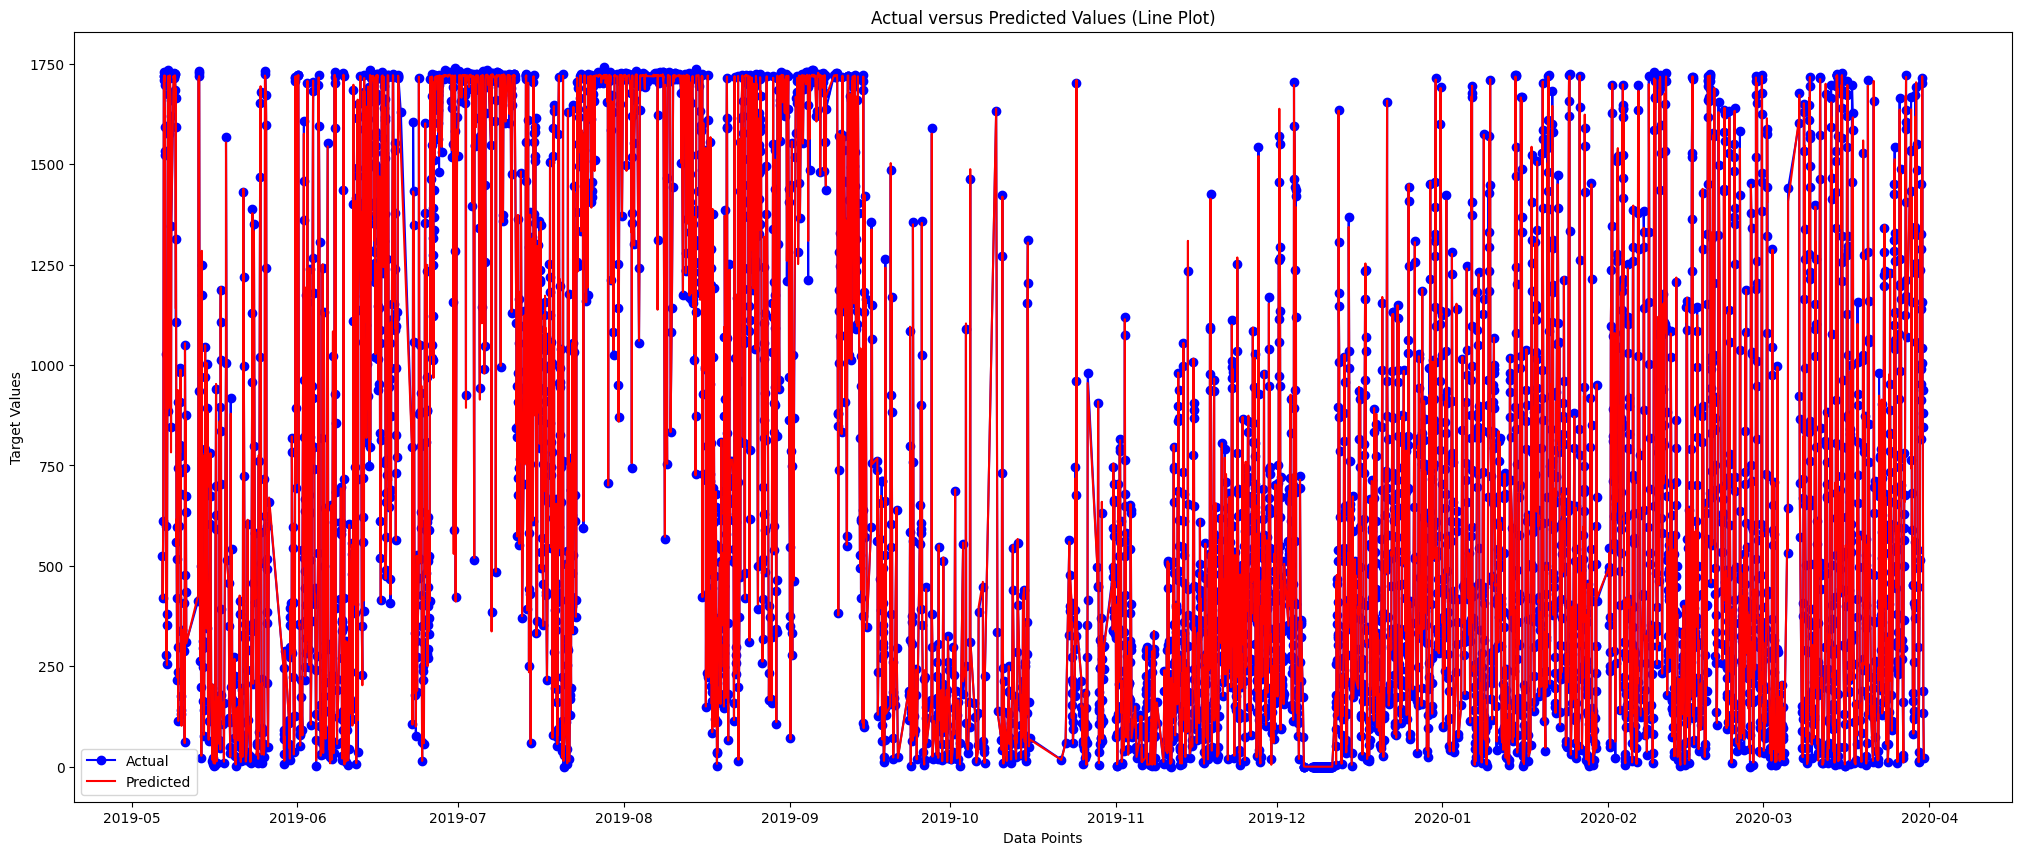

In [24]:
# Step 2: Get predictions on the test data
#pred = rand_forest_model.predict(X_test)
plt.figure(figsize=(25, 10))
plt.plot(X_test.index, y_test, label='Actual', color='blue', marker='o')
plt.plot(df_predictions.index, df_predictions['Predicted'], label='Predicted', color='red')

# Set plot labels and title
plt.xlabel('Data Points')
plt.ylabel('Target Values')
plt.title('Actual versus Predicted Values (Line Plot)')

# Show a legend
plt.legend()

# Show the plot
plt.show()